|Name|Student ID|
|:--|:--|
|Caitao Zhan|111634527|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1 Import Data & Cleaning & Visualization

## 1.1 Data Summary

The data is very big (according to RAM). Instead of importing all four data sets, I will only import only one of the four to do some visualization so that I can get some quick feeling and intuition on the data.

In summery, in the first dataset (combined_data_1.txt), there are over **24 million** rows. Every row has **3** columns. Actually, there is a conceptually **4th** column, but it is at the first line of each new movie, followed by a colon, not a comma.

**Features**:

1. Movie ID
2. Customer ID
3. Rating
4. Date of the rating

To begin with, visualize the **customer** and **rating** feature. Only using data from the **first data file**, about 1/4 of all movies.

In [139]:
df1 = pd.read_csv('../data/combined_data_1.txt', names = ['Customer', 'Rating'])

In [4]:
df1.head()

,Customer,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [33]:
movie_num = df1.isnull().sum()[1]

In [5]:
df1_clean = df1.dropna(how='any')

In [8]:
customer_num = df1_clean['Customer'].nunique()

In [9]:
rating_num = df1_clean['Rating'].count()

In [35]:
print('movie number = %d, customer number = %d, rating counts = %d' %(movie_num, customer_num, rating_num))

movie number = 4499, customer number = 470758, rating counts = 24053764


## 1.2 Group by Ratings

In [18]:
rating_group = df1_clean.groupby('Rating').count()

In [19]:
rating_group

,Customer
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


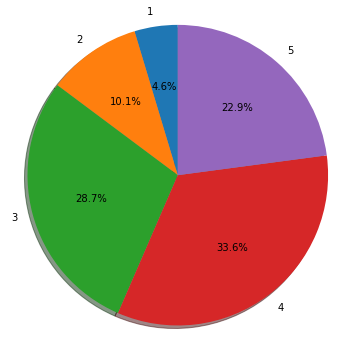

In [66]:
fig1, ax1 = plt.subplots(figsize=(6,6))
labels = '1', '2', '3', '4', '5'
ax1.pie(rating_group, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

**4-point** rating is the most with about **8 million** accounting **33.6%**. **1-point** is the least with about **1 million** accounting **4.6%**.

## 1.3 Group by Customers

In [68]:
customer_group = df1_clean.groupby('Customer').count()

In [76]:
customer_group.describe()

,Rating
count,470758.000000
mean,51.095816
std,74.405055
min,1.000000
25%,8.000000
50%,24.000000
75%,64.000000
max,4467.000000


In [88]:
customer_group_rating = np.log2(customer_group.Rating)

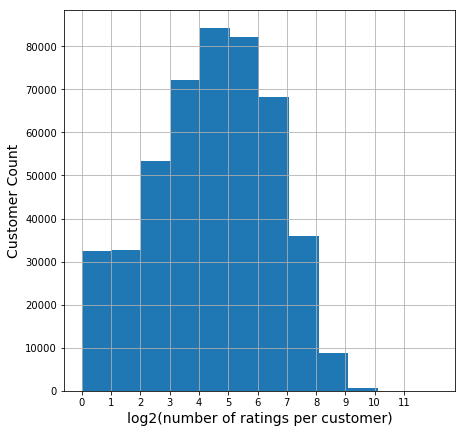

In [100]:
ax = customer_group_rating.plot.hist(bins=12, figsize=(7,7))
ax.set_xlabel('log2(number of ratings per customer)', fontsize=14)
ax.set_ylabel('Customer Count', fontsize=14)
ax.set_xticks(range(0,12))
ax.grid()

From the figure, there is about **36,000** customers who rated **128~256** ($log_2{128}=7$) movies. We do a logarithm on the number of ratings per customer to make the plot looks better.

## 1.4 Movie ID

Movie ID does not show up in every row of the dataset, so we need to solve it by adding the Movie ID to each row.

In [140]:
df = df1

In [144]:
df_movie = pd.DataFrame(pd.isnull(df.Rating))
df_movie = df_movie[df_movie['Rating']==True]
df_movie = df_movie.reset_index()

In [149]:
df_movie.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [150]:
movie_ids = []
movie_id  = 1

for i,j in zip(df_movie['index'][1:], df_movie['index'][:-1]):
    tmp = np.full((1, i-j-1), movie_id)
    movie_ids = np.append(movie_ids, tmp)
    movie_id = movie_id +1

In [164]:
last_movie = np.full((1, len(df) - df_movie.iloc[-1, 0] -1), movie_id)
movie_ids = np.append(movie_ids, last_movie)

In [167]:
print('length = %d' % len(movie_ids))
print(movie_ids)

length = 24053764
[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   4.49900000e+03
   4.49900000e+03   4.49900000e+03]


In [ ]:
df = df.dropna()
df['Movie'] = movie_ids.astype(int)
df['Customer'] = df['Customer'].astype(int)

In [173]:
df.head()
df.iloc[::5000000, :]

,Customer,Rating,Movie
1,1488844,3.0,1
5000996,501954,2.0,996
10001962,404654,5.0,1962
15002876,886608,2.0,2876
20003825,1193835,2.0,3825
